# Machine Learning exercise 3: Sinus
2021 07 13 Maarten Pennings

I got a nice machine learning (ML) intro with the two previous exercises.
I wanted to make a next step, getting some ML running on a tiny device.

I found [Easy TinyML on ESP32 and Arduino](https://www.hackster.io/news/easy-tinyml-on-esp32-and-arduino-a9dbc509f26c), 
which replicates an exercise from the book [**TinyML, Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers** by Pete Warden and Daniel Situnayake](https://tinymlbook.com/). 
The book is an e-book, and you can get a sample of the first chapters. 
The website now only gives 2 chapters, but in the past that was six (you might still find that somewhere), 
which includes the important chapter _Chapter 4. The “Hello World” of TinyML: Building and Training a Model_.
This "Hello World" of ML is actually a network that "predicts" the _sin(x)_ given _x_.

It seems that this "Hello World" was even a standard example of [tensorflow](https://www.tensorflow.org/); 
it was on the [github](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro).
But as of June 25, 2021, the Tensorflow Lite for microcontrollers codebase has moved to a stand-alone 
[github repository](https://github.com/tensorflow/tflite-micro). We find it down deep [https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world).



## The project directory
Check my first exercise for details. Basically you need

- Python on your system
- Start with an empty project directory; then copy `requirements.txt`, `setup.bat`, `run.bat`, and `sinus.ipynb` into it.
- Run `setup.bat` to create a virtual Python environment (in subdirectory `env` in the project directory).
- Note that several packages will be installed (including Jupyter), as listed in `requirements.txt`.
- Run `run.bat` to run the Jupyter server and client (web page in you browser).
- Open this file (`sinus.ipynb`).


## Try pi
We don't need a data-set, we just use Python's `math` libary to get `sin()` data.
Let's try it.

In [1]:
import math

xs=[]
ys=[]
for i in range(50) :
    x = 2*math.pi * i/50.0
    y = math.sin(x)
    xs.append(x)
    ys.append(y)

xs[25],ys[25]

(3.141592653589793, 1.2246467991473532e-16)

Looks good, for the item halfway, `x` is about pi and `y` is about 0. Let's try to plot it.
The `'g.'` means green dots.

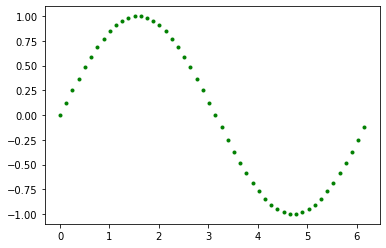

In [2]:
import matplotlib.pyplot as plt
plt.plot(xs,ys,'g.');

## Data set

Let's now be a bit more serious about the data set. We use numpy to work with vectors of floats.

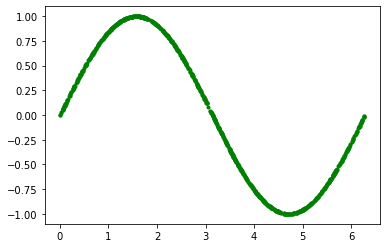

In [3]:
import numpy as np

SAMPLES = 1000
x_values = np.random.uniform( low=0.0, high=2*math.pi, size=SAMPLES )
np.random.shuffle(x_values)
y_values = np.sin(x_values) # maps `sin` on all elements of vector `x_values`
plt.plot(x_values,y_values,'g.');

Let's pretend our data is messy.

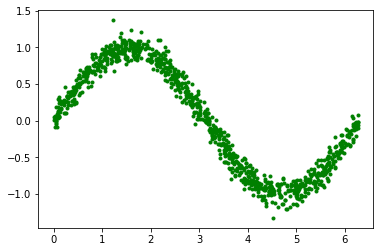

In [4]:
y_values += 0.1 * np.random.randn(SAMPLES)
plt.plot(x_values,y_values,'g.');

We need to split the data. For the first time not in two parts (train and test) but in three: train, validate, and test.

We use the train set during the training phase to create the model. The validate set is also used during training to compute the _loss_. Using fresh data (validate instead of train) gives a more reliable loss indicator. The test set is used when we believe the model is finished.

In [8]:
FRACTION_TRAIN = 0.6
FRACTION_VALIDATE = 0.2

NUM_TRAIN = int(SAMPLES*FRACTION_TRAIN)
NUM_VALIDATE = int(SAMPLES*FRACTION_VALIDATE)
NUM_TEST = SAMPLES - NUM_TRAIN - NUM_VALIDATE

x_train,x_validate,x_test = np.split(x_values,[ NUM_TRAIN, NUM_TRAIN+NUM_VALIDATE ])
y_train,y_validate,y_test = np.split(y_values,[ NUM_TRAIN, NUM_TRAIN+NUM_VALIDATE ])

We can plot the three data sets.

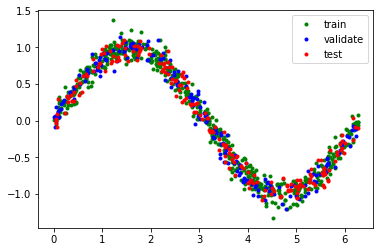

In [9]:
plt.plot(x_train,y_train,'g.',label='train')
plt.plot(x_validate,y_validate,'b.',label='validate')
plt.plot(x_test,y_test,'r.',label='test')
plt.legend();

## Setting up a network

We start as before, with the `keras` interface of `tensorflow`. We create an (empty) neural network model; the `sequential` indicates that layers are in sequence. We will start with a simple model (`model_1`) and later make a more laborate one.

In [11]:
from tensorflow import keras
model_1 = keras.models.Sequential()

We built on the input layer, which is just a scalar, hence the `input_shape=(1,)`. A monochrome image of 10×10 would have `input_shape=(10,10)`, and a color one `input_shape=(10,10,3)`. 

The layer we create is `Dense`, which means that every neuron of this layer is connected _all_ outputs of the previous, in our case that is the input layer with 1 value. If the input was really big, like an image, we would not use `Dense` but rather a "sweeping kernel", i.e. a convolution (`Conv2D`).

This layer will have 9 outputs, so it will have 9 neurons each having one input. Recall that a neuron has weights for all its inputs, and one bias, so the computation for neuron _i_ in layer 1 is simple: $value_{1,i} = relu(weight_{1,i} \cdot value_0 + bias_{1,i})$, where $value_0$ is the value of the previous layer, that is the input scalar. Also note that $relu(x) = 0 \mathbin{\mbox{max}} x$.

In [15]:
model_1.add( keras.layers.Dense(9, activation='relu', input_shape=(1,)) )

We keep `model_1` simple, and average the 9 neurons to one. So we will have 1 neuron, with 9 inputs: $value_2 = (\sum_{0\leq i<9} weight_{2,i} \cdot value_{1,i})+bias_2$. This will be the output of our network: we want a non-activated result and therefore we do not specify an activation function.

In [16]:
model_1.add( keras.layers.Dense(1) )

This is a light model, so we can easily draw it.

![model_1](model1.png)

Observe that the first layer has 9 neurons each with 1 weight and 1 bias (18 parameters) and the second layer has 1 neuron with 9 weights and 1 bias (10 parameters). In total 28 parameters.

Let's check that

In [11]:
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
